## ResNet50



In [ ]:
from scipy.io import loadmat
data=loadmat("C:/Users/ANSUMAN/Downloads/archive (2)/sat-6-full.mat")

In [18]:
#split and process data
import numpy as np
import pandas as pd

def fixaxes(inarr): #matlab format has long axis in last position, move to 1st to match tensorflow
  return np.rollaxis(inarr,3,0)

#load ndarrays from mat dictionary
trainX=fixaxes(data['train_x']) 
trainy=data['train_y'].T
testX=fixaxes(data['test_x'])
testy = data['test_y'].T
assert np.all(trainX[0,:10,0,0] == data['train_x'][:10,0,0,0])


In [ ]:
# get vector of categories for interpreting outputs
anno=pd.read_csv("C:/Users/ANSUMAN/Downloads/archive (2)/sat6annotations.csv",header=None)
anno.head()
categories=anno.loc[:,0].to_dict()
ycat=pd.DataFrame(trainy).idxmax(axis=1).map(categories)

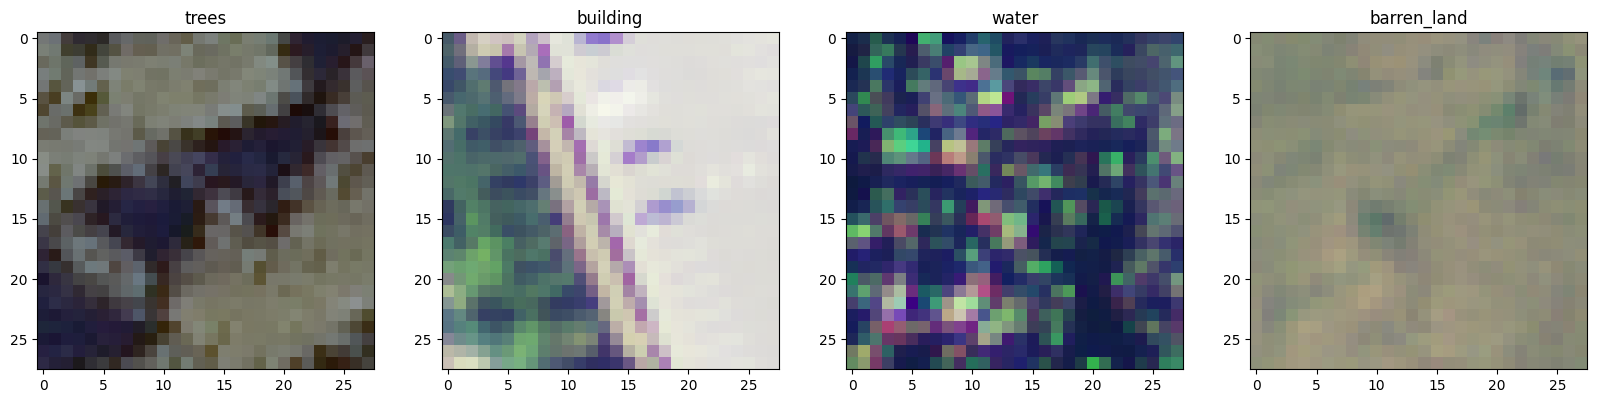

In [20]:
# look at a few tiles, visible bands
import matplotlib.pyplot as plt 
fig,axs=plt.subplots(1,4,figsize=(20,10))
axs[0].imshow(trainX[0,:,:,:3])
axs[1].imshow(trainX[6,:,:,:3])
axs[2].imshow(trainX[2,:,:,:3])
axs[3].imshow(trainX[8,:,:,:3])
axs[0].set_title(ycat.loc[0])
axs[1].set_title(ycat.loc[6])
axs[2].set_title(ycat.loc[2])
axs[3].set_title(ycat.loc[8]);

# Implement transfer learning with Keras

A classification model is implemented using the ResNet network with a dense classifier backend.

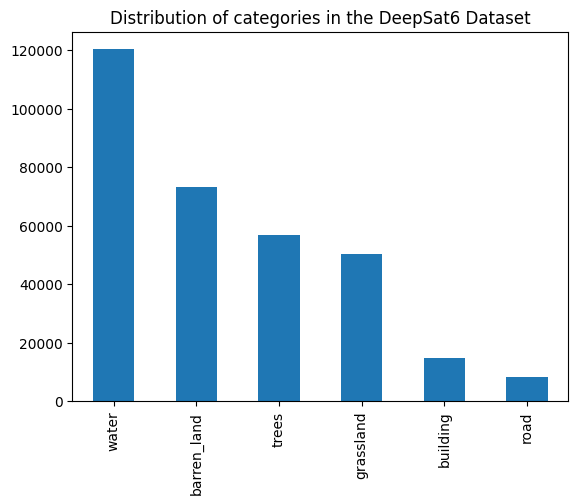

In [21]:
#look at balance between categories:  we see that the categories are not evenly distributed
ycounts=ycat.value_counts()
ycounts.plot.bar()
plt.title('Distribution of categories in the DeepSat6 Dataset');

In [22]:
#get shuffled indices for train-val split
import random
nimg=len(trainX)
ixs=list(range(nimg))
random.shuffle(ixs)
train_ix=ixs[:280000]
val_ix=ixs[280000:]

In [23]:
#create generators to feed imagery to network
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator=train_datagen.flow(trainX[train_ix,:,:,:3],trainy[train_ix],batch_size=512) #puts 280,000 images in train, excludes IR band
val_generator=val_datagen.flow(trainX[val_ix,:,:,:3],trainy[val_ix],batch_size=512) #puts 64,800 records in val


In [24]:
from tensorflow.keras import models, layers
from tensorflow.keras.applications import ResNet50

# Load the pre-trained ResNet50 model without the top layer
cbase = ResNet50(weights='imagenet', include_top=False, input_shape=(56, 56, 3))
cbase.trainable = False  # Freeze the convolutional base

# Build the sequential model
tmodel = models.Sequential()
# Use UpSampling2D to upscale the input images
tmodel.add(layers.UpSampling2D(size=(2, 2), input_shape=(28, 28, 3)))  # Upsample to (56, 56, 3)
tmodel.add(cbase)
tmodel.add(layers.Flatten())

# Add fully connected layers
tmodel.add(layers.Dense(512, activation='relu'))
tmodel.add(layers.Dropout(0.5))
tmodel.add(layers.Dense(6, activation='softmax'))

# Display the model summary
tmodel.summary()


c:\Users\dksai\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\up_sampling2d.py:72: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ up_sampling2d_1 (UpSampling2D)  │ (None, 56, 56, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2, 2, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,785,606 (105.99 MB)

 Trainable params: 4,197,894 (16.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [25]:
#Compile model, load
from tensorflow.keras import optimizers
tmodel.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(learning_rate=0.0001),metrics=['accuracy'])

load_weights=False

In [26]:
from keras.callbacks import EarlyStopping
early_stop_mon=EarlyStopping(patience=3)
if load_weights!=True:
    history=tmodel.fit(train_generator,steps_per_epoch=545,epochs=30,validation_data=val_generator,validation_steps=20,callbacks=[early_stop_mon])

Epoch 1/30


c:\Users\dksai\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


545/545 ━━━━━━━━━━━━━━━━━━━━ 695s 1s/step - accuracy: 0.4209 - loss: 1.4796 - val_accuracy: 0.5418 - val_loss: 1.0978
Epoch 2/30
  2/545 ━━━━━━━━━━━━━━━━━━━━ 10:38 1s/step - accuracy: 0.5742 - loss: 1.0714

c:\Users\dksai\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


545/545 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.5567 - loss: 1.0785 - val_accuracy: 0.5667 - val_loss: 1.0947
Epoch 3/30
545/545 ━━━━━━━━━━━━━━━━━━━━ 791s 1s/step - accuracy: 0.5770 - loss: 1.0698 - val_accuracy: 0.6331 - val_loss: 0.9518
Epoch 4/30
545/545 ━━━━━━━━━━━━━━━━━━━━ 40s 69ms/step - accuracy: 0.6251 - loss: 0.9732 - val_accuracy: 0.6555 - val_loss: 0.9506
Epoch 5/30
545/545 ━━━━━━━━━━━━━━━━━━━━ 923s 2s/step - accuracy: 0.6389 - loss: 0.9422 - val_accuracy: 0.6684 - val_loss: 0.8318
Epoch 6/30
545/545 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.6572 - loss: 0.8969 - val_accuracy: 0.6614 - val_loss: 0.8569
Epoch 7/30
545/545 ━━━━━━━━━━━━━━━━━━━━ 656s 1s/step - accuracy: 0.6787 - loss: 0.8540 - val_accuracy: 0.7230 - val_loss: 0.7884
Epoch 8/30
545/545 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - accuracy: 0.6778 - loss: 0.8369 - val_accuracy: 0.7184 - val_loss: 0.7915
Epoch 9/30
545/545 ━━━━━━━━━━━━━━━━━━━━ 594s 1s/step - accuracy: 0.7039 - loss: 0.7926 - val_accuracy: 0

In [ ]:
save_weights=True
if save_weights:
   tmodel.save_weights("C:/Users/ANSUMAN/Downloads/archive (2)/res_baseline.weights.h5")
   #dump history too
   hist_df=pd.DataFrame.from_dict(history.history)
   hist_df.to_csv('C:/Users/ANSUMAN/Downloads/archive (2)/res_history.csv')


In [ ]:
tmodel.load_weights('C:/Users/ANSUMAN/Downloads/archive (2)/res_baseline.weights.h5')


In [ ]:
hist=pd.read_csv('C:/Users/ANSUMAN/Downloads/archive (2)/res_history.csv')

# Evaluate model fit

The accuracy and loss metrics saved to the history variable over the course of model fitting are plotted to observe the improvement in model fit over each training iteration, and to check for overfitting.

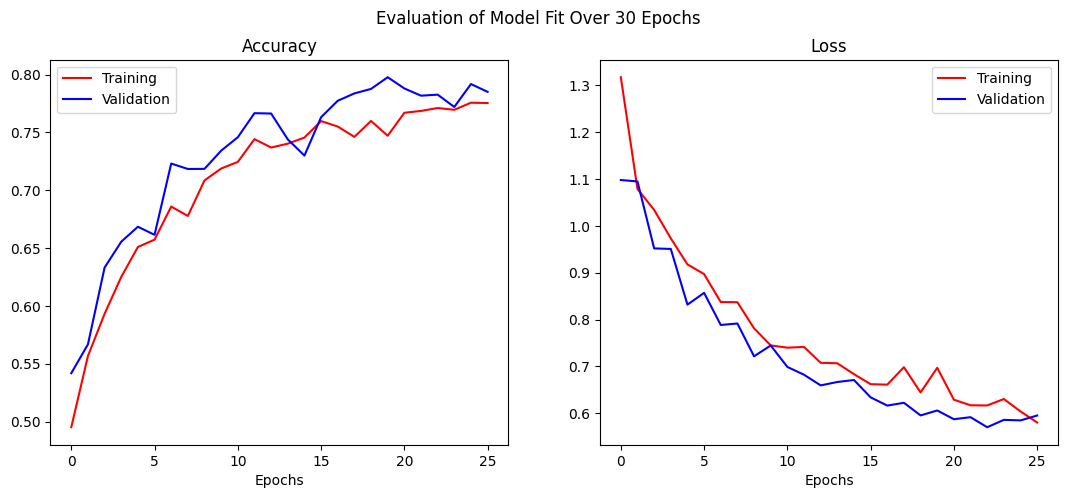

In [30]:
# Plot progression of model fit over each epoch
# adapted from Deep Learning With Python (Chollet)
h=hist#history.history
epochs = range(len(h['accuracy']))
fig,ax=plt.subplots(1,2,figsize=(13,5))
ax[0].plot(epochs, h['accuracy'], 'r', label='Training')
ax[0].plot(epochs, h['val_accuracy'], 'b', label='Validation')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend()
ax[1].plot(epochs, h['loss'], 'r', label='Training')
ax[1].plot(epochs, h['val_loss'], 'b', label='Validation')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend()
plt.suptitle('Evaluation of Model Fit Over 30 Epochs');


#Evaluate held-out data

The model is applied to classify the DeepSat-6 training dataset.

In [31]:
# Look at predictions on held-out data
testX_rescaled=testX[:,:,:,:3]/255
predy=tmodel.predict(testX_rescaled)

2532/2532 ━━━━━━━━━━━━━━━━━━━━ 217s 85ms/step


In [32]:
#get pd Series of predicted and actual categories for test dataset
testycat=pd.DataFrame(testy).idxmax(axis=1).map(categories) #actual
testycat_pred=pd.DataFrame(predy).idxmax(axis=1).map(categories) #pred

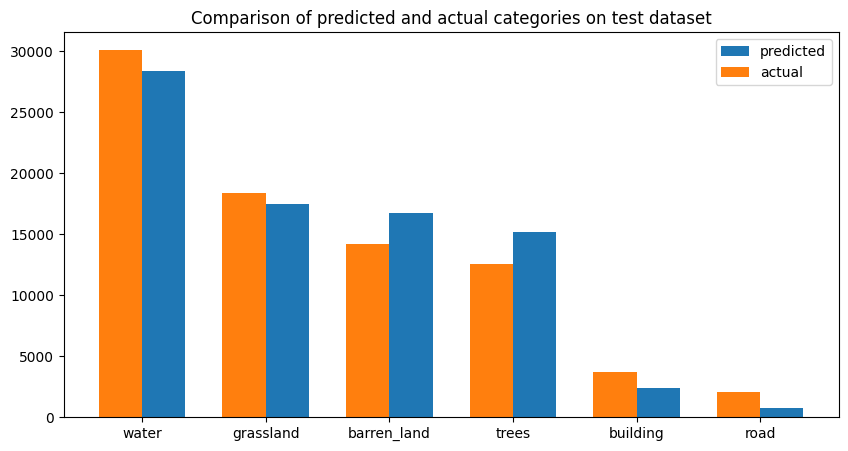

In [33]:
#Plot comparison of pred vs actual on test
pred_df=testycat_pred.value_counts()
act_df=testycat.value_counts()
fig,ax=plt.subplots(figsize=(10,5))
ind=np.arange(6)
width=0.35
pred=ax.bar(ind+width,pred_df.values,width=width,label='predicted')
act=ax.bar(ind,act_df.values,width=width,label='actual')
ax.set_xticks(ind+width/2)
ax.set_xticklabels(pred_df.index)
ax.legend()
ax.set_title('Comparison of predicted and actual categories on test dataset');

In [34]:
#get prediction errors
compare_df=pd.concat([testycat,testycat_pred],axis=1)
compare_df.columns=['actual','predicted']
compare_df=compare_df.assign(mismatch=compare_df.actual!=compare_df.predicted)
compare_df.loc[compare_df.mismatch].head()

,actual,predicted,mismatch
3,barren_land,grassland,True
11,trees,water,True
14,trees,water,True
19,building,road,True
25,building,barren_land,True


In [35]:
#combine dfs, look at probabilities for mismatch cases
#the second highest probability is often the correct classification
pd.set_option('display.float_format', lambda x:'%.3f' % x)
pred_df=pd.concat([pd.DataFrame(predy,columns=categories.values()),compare_df],axis=1)
pred_df.loc[pred_df.mismatch==True].head(10)
#additional work: create column with rank of the actual class, prove that it is often #2 

,building,barren_land,trees,grassland,road,water,actual,predicted,mismatch
3,0.000,0.077,0.255,0.633,0.000,0.034,barren_land,grassland,True
11,0.036,0.142,0.231,0.058,0.017,0.516,trees,water,True
14,0.005,0.011,0.372,0.017,0.002,0.592,trees,water,True
19,0.413,0.024,0.034,0.008,0.468,0.053,building,road,True
25,0.143,0.833,0.000,0.005,0.019,0.000,building,barren_land,True
26,0.000,0.016,0.146,0.577,0.002,0.259,water,grassland,True
27,0.005,0.380,0.016,0.579,0.009,0.011,barren_land,grassland,True
31,0.005,0.246,0.053,0.488,0.008,0.200,water,grassland,True
34,0.074,0.885,0.000,0.022,0.019,0.000,building,barren_land,True
37,0.001,0.145,0.117,0.635,0.002,0.100,barren_land,grassland,True


In [36]:
#overall total of correct vs incorrect predictions
compare_df['mismatch'].value_counts()

mismatch
False    63622
True     17378
Name: count, dtype: int64

In [37]:
#accuracy on test dataset
print('Overall accuracy on test dataset: {0:.3f}'.format(1-(compare_df.mismatch.sum()/compare_df.mismatch.count())))

Overall accuracy on test dataset: 0.785


In [38]:
# Look at confusion matrix, classification report
from sklearn.metrics import classification_report,confusion_matrix
print('Classification Report:')
print(classification_report(testycat,testycat_pred))
print('Confusion Matrix:')
print(confusion_matrix(testycat,testycat_pred))
print('\nNumber of Correct Classifications:')
correct=compare_df.loc[~compare_df.mismatch].groupby(['actual','predicted']).count()
correct.columns=['Correct']
print(correct) #check order of entries along diagonal of confusion matrix

Classification Report:
              precision    recall  f1-score   support

 barren_land       0.83      0.76      0.80     18367
    building       0.77      0.49      0.60      3714
   grassland       0.59      0.83      0.69     12596
        road       0.64      0.23      0.33      2070
       trees       0.74      0.79      0.77     14185
       water       0.90      0.85      0.88     30068

    accuracy                           0.79     81000
   macro avg       0.75      0.66      0.68     81000
weighted avg       0.80      0.79      0.78     81000

Confusion Matrix:
[[13959   114  3272    42   773   207]
 [ 1201  1838    44   178   134   319]
 [  741    11 10394    30   959   461]
 [  628   323   279   469    37   334]
 [  114    46  1369     4 11255  1397]
 [   92    42  2161    15  2051 25707]]

Number of Correct Classifications:
                         Correct
actual      predicted           
barren_land barren_land    13959
building    building        1838
grassland   g

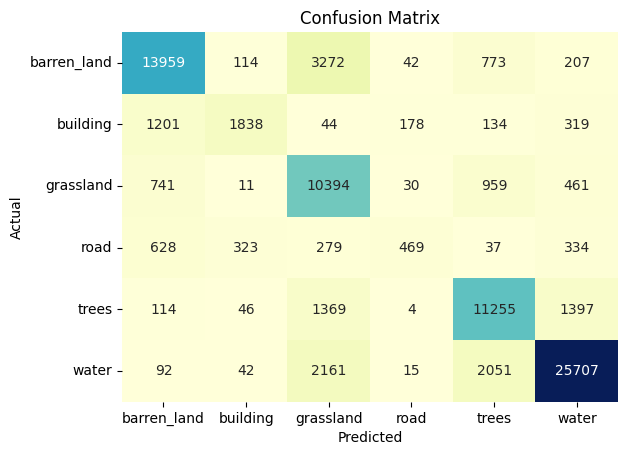

In [39]:
#plot confusion matrix as heatmap
import seaborn as sns
cm=confusion_matrix(testycat,testycat_pred)
labels=correct.index.get_level_values(0).values
ax=sns.heatmap(cm,xticklabels=labels,yticklabels=labels,annot=True,fmt='d',cmap="YlGnBu",cbar=False)
ax.set_title('Confusion Matrix')
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted');

In [40]:
# grasslands have slightly lower recall wrt other categories 
gl_mismatch=compare_df.loc[(compare_df.mismatch)&(compare_df.actual=='grassland')]
print(gl_mismatch['predicted'].value_counts()) #roads most often misclassified as buildings
gl_mismatch['ixcopy']=gl_mismatch.index
mismatches=gl_mismatch.groupby('predicted')['ixcopy'].first()

predicted
trees          959
barren_land    741
water          461
road            30
building        11
Name: count, dtype: int64


C:\Users\dksai\AppData\Local\Temp\ipykernel_1076\3750802002.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gl_mismatch['ixcopy']=gl_mismatch.index


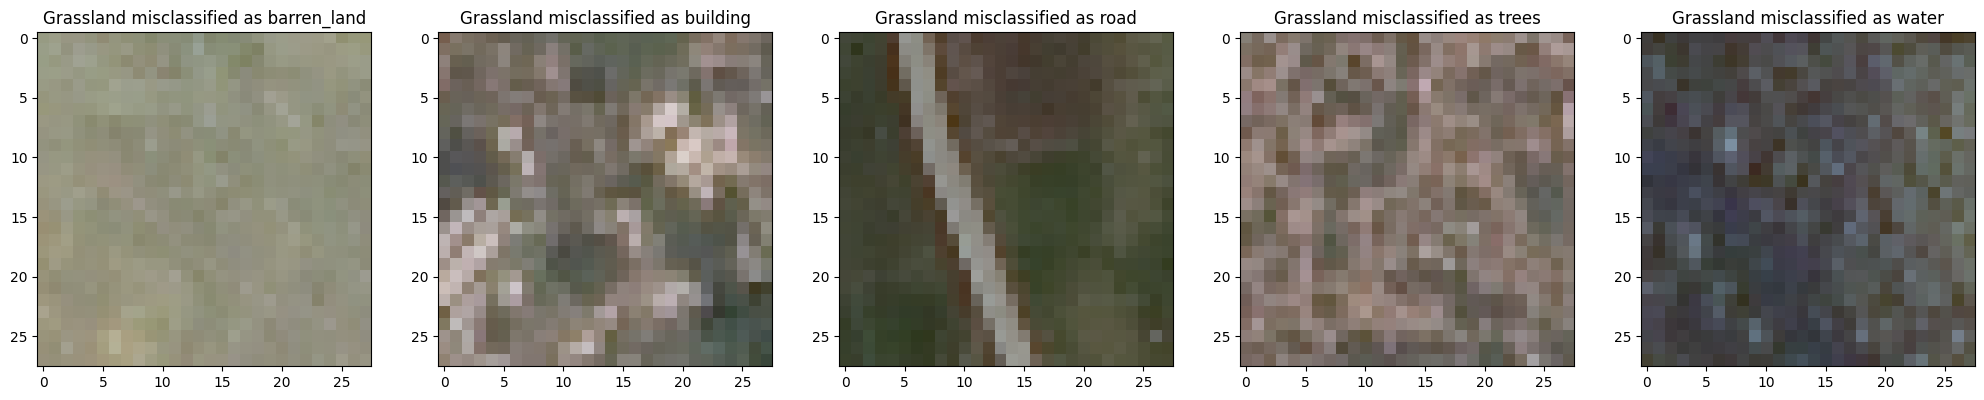

In [41]:
#view some mismatches
fig,axs=plt.subplots(1,5,figsize=(25,10))
axix=0
for i,v in mismatches.items():
  axs[axix].imshow(testX[v,:,:,:3])
  axs[axix].set_title('Grassland misclassified as {}'.format(i))
  axix+=1

In [ ]:
from tensorflow.keras.applications import ResNet50

# Load the pre-trained ResNet50 model without the top layer
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(56, 56, 3))

# Get the output shape of the convolutional base
output_shape = resnet_base.output_shape
print("Output shape of convolutional base:", output_shape)

# Calculate the total number of features
feature_count = output_shape[1] * output_shape[2] * output_shape[3]
print("Total number of features extracted:", feature_count)